In [1]:
#essential tools
from __future__ import print_function
import numpy as np
import awkward
import uproot_methods

In [2]:
# convenience feature 1: numpythonic weights and corrections 
# (this package name needs to change)
import fnal_column_analysis_tools.lookup_tools as lookup_tools
# convenience feature 2: a nice wrapper to dress up awkward tables as canonical "analysis objects"
# with access patterns like object.p4.pt or object.scaleFactor, etc.
# (this package name needs to be more descriptive)
from fnal_column_analysis_tools.analysis_objects import JaggedDecoratedFourVector, JaggedWithLorentz

In [3]:
# import a bunch of correction histograms
# wrapped in numpythonic interface
weights_ext = lookup_tools.extractor()
correction_data = open("newCorrectionFiles.txt").readlines()
weights_ext.add_weight_sets(correction_data)
weights_ext.finalize()
weights_eval = weights_ext.make_evaluator()
#what scale factors / corrections do we have available? (uncomment to dump this)
#dir(weights_eval)

In [4]:
#let's create some fake data
np.random.seed(4)
nrows = 100000

nwide = 4

counts1 = np.minimum(np.random.exponential(0.5, size=nrows).astype(int), 20)
counts2 = np.minimum(np.random.exponential(0.5, size=nrows).astype(int), 20)
content1_pxy = np.random.normal(loc=20.0,scale=5.0,size=np.sum(counts1)*2).reshape((-1, 2))
content2_pxy = np.random.normal(loc=20.0,scale=5.0,size=np.sum(counts2)*2).reshape((-1, 2))
content1_z = np.random.normal(loc=0, scale=55, size=np.sum(counts1))
content2_z = np.random.normal(loc=0, scale=55, size=np.sum(counts2))
awk_vector1 = JaggedWithLorentz.fromcounts(counts1,uproot_methods.TLorentzVectorArray(content1_pxy[:,0],
                                                                                      content1_pxy[:,1],
                                                                                      content1_z[:],
                                                                                      np.sqrt(content1_pxy[:,0]**2 + 
                                                                                              content1_pxy[:,1]**2 + 
                                                                                              content1_z[:]**2 )))
awk_vector2 = JaggedWithLorentz.fromcounts(counts2,uproot_methods.TLorentzVectorArray(content2_pxy[:,0],
                                                                                      content2_pxy[:,1],
                                                                                      content2_z[:],
                                                                                      np.sqrt(content2_pxy[:,0]**2 + 
                                                                                              content2_pxy[:,1]**2 + 
                                                                                              content2_z[:]**2 )))

content1 = np.random.normal(size=np.sum(counts1))
content2 = np.random.normal(size=np.sum(counts2))
awk_scalar1 = awkward.JaggedArray.fromcounts(counts1, content1)
awk_scalar2 = awkward.JaggedArray.fromcounts(counts2, content2)

In [5]:
#make the basic tables of "muons" and "electrons"
muons = JaggedDecoratedFourVector.fromcounts(counts1,
                                             p4 = awk_vector1.content,
                                             mva1 =  awk_scalar1.content,
                                             )
electrons = JaggedDecoratedFourVector.fromcounts(counts2,
                                                 p4 = awk_vector2.content,
                                                 mva2 = awk_scalar2.content,
                                                 )

In [6]:
# we're going to want muon and electron scale factors
# let's figure out how they're indexed! (uncomment to see)
#print(weights_eval["muScaleFactor_MediumId_Iso"])
#print(weights_eval["eleScaleFactor_MediumId_MVA_POG"])

In [7]:
#apply the previously loaded scale factors for the "muons" and "electrons"
#and put them in the objects
# we need the |eta| of the muons for their scale factors, maybe we should add this to TLorentzVector?
muons["SF"] = weights_eval["muScaleFactor_MediumId_Iso"](np.absolute(muons.p4.eta),muons.p4.pt)
electrons["SF"] = weights_eval["eleScaleFactor_MediumId_MVA_POG"](electrons.p4.eta,electrons.p4.pt)

In [8]:
(muons.p4.pt > 5) & (np.abs(muons.p4.eta) < 1.5)

<JaggedArray [[False] [] [ True] ... [] [] [ True]] at 00011ca271d0>

In [9]:
#make analysis selections
selected_muons = muons[(muons.p4.pt > 5) & (np.absolute(muons.p4.eta) < 1.5)]
selected_electrons = electrons[electrons.p4.pt > 5]
dileptons = selected_muons.cross(selected_electrons)
selected_dileptons = dileptons[dileptons.p4.mass > 5]

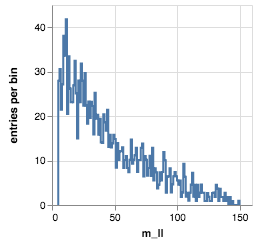

In [10]:
#plot our monte-carlo with weights
from histbook import Hist, beside, groupby, below
from histbook import bin as hbin

#flatten selected data to plot it
# i.e. build a simple list from the mass values selected from all events
m_flat = selected_dileptons.p4.mass.flatten()
scaleFact = (selected_dileptons.at(0).SF*selected_dileptons.at(1).SF).flatten()


#make and fill a histogram of the masses
dilepMass = Hist(hbin("m_ll", 145, 5, 150), weight="weight")
dilepMass.fill(m_ll=m_flat,weight=scaleFact)

#plot it
from vega import VegaLite as canvas
#import vegascope; canvas = vegascope.LocalCanvas()
dilepMass.step("m_ll").to(canvas)